Here I will use this great library: [facenet-pytorch](https://github.com/timesler/facenet-pytorch)

In [1]:
# !pip3 install facenet-pytorch

In [2]:
from facenet_pytorch import MTCNN, InceptionResnetV1

import torch
import numpy as np
from scipy.spatial.distance import cosine

from PIL import Image

from os import listdir
from os.path import join
from math import ceil
import pickle

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.metrics import accuracy_score

import matplotlib
import matplotlib.pyplot as plt

In [3]:
data_path = '/home/egor/job/face_detection/data'

# Face extraction

In [4]:
mtcnn = MTCNN()

In [5]:
faces = {}
persons = listdir(join(data_path, 'train'))

for person in persons:
    images = listdir(join(data_path, 'train', person))
    
    for i, img_name in enumerate(images):
        pil_image = Image.open(join(data_path, 'train', person, img_name)).convert('RGB')
        
        # mtcnn detections
        face = mtcnn(pil_image)

        if face is None:
            print(f'No faces found in image {img_name} of {person}')
            continue
            
        if person not in faces:
            faces[person] = []
            
        faces[person].append(face)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Faces were whitened


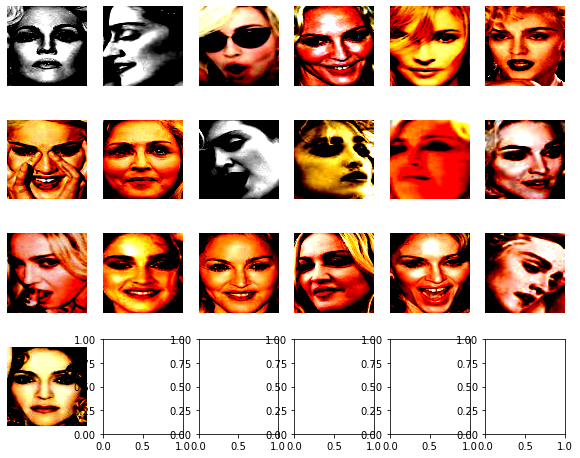

In [6]:
l = len(faces['madonna'])
cols = 6
rows = ceil(l / cols)

print('Faces were whitened')
fig, ax = plt.subplots(rows, cols, figsize=(10, 8))
for i, face in enumerate(faces['madonna']):
    row, col = i // cols, i % cols
    
    ax[row][col].imshow(face.permute(1,2,0).detach().cpu().numpy())
    ax[row][col].axis('off')

# Face2vec

In [7]:
facenet = InceptionResnetV1(pretrained='vggface2').eval()

In [8]:
face_vectors = {}

for person, _faces in faces.items():
    face_batch = torch.stack(_faces)
    vectors = facenet(face_batch).detach().cpu().numpy()
    
    face_vectors[person] = [vec for vec in vectors]

In [9]:
pickle.dump(face_vectors, open(join(data_path, 'train_face_vectors.pkl'), "wb"))

In [10]:
names, vectors = [], []

for person, vecs in face_vectors.items():
    for i, vec in enumerate(vecs):
        if i > 5:
            break
        names.append(f'{i}_{person}')
        vectors.append(vec)

In [11]:
dists = np.array([[cosine(v1, v2) for v2 in vectors] for v1 in vectors])

In [12]:
# code borrowed from matplotlib docs 
# https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=90, va="bottom", fontsize=14)

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

On this heatmap we see cosine distances between images. The less cosine distance is - the more similar the images.

From the plot we see that basically images of one person are more similar to other images of his face than to images of different people. 

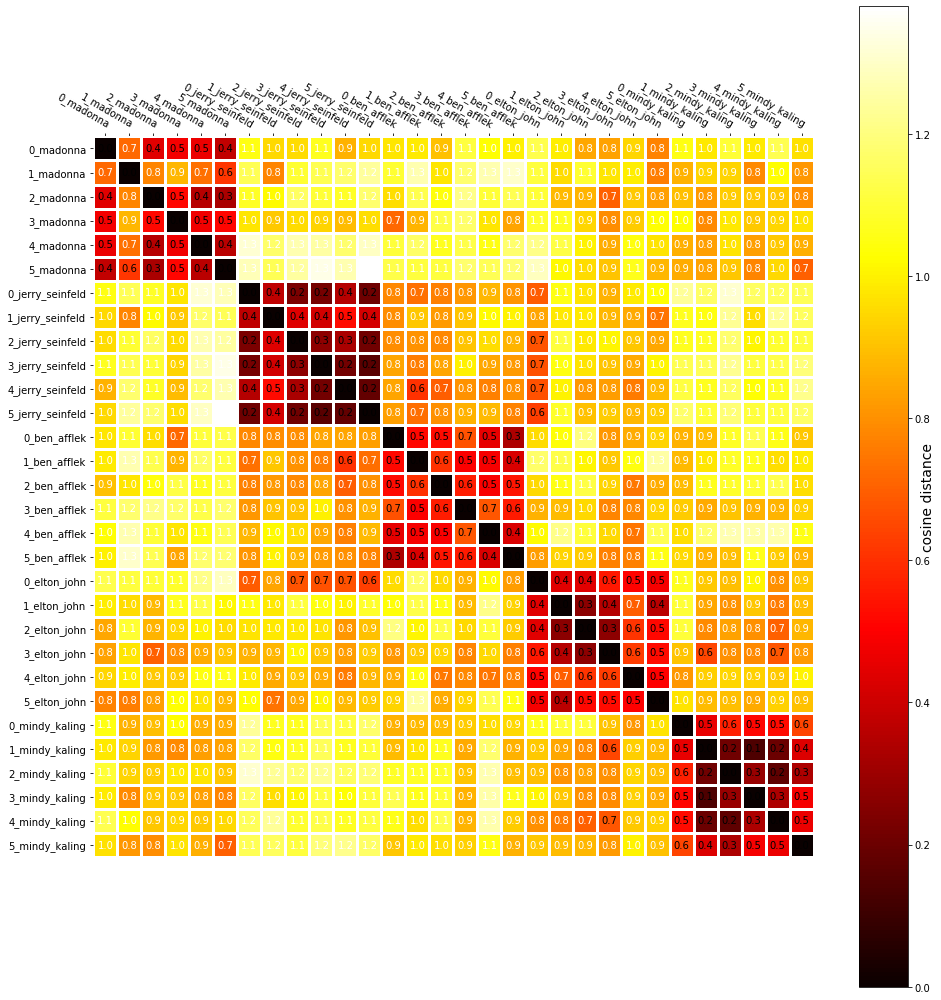

In [13]:
fig, ax = plt.subplots(figsize=(14,14))

im, cbar = heatmap(dists, names, names, ax=ax,
                   cmap="hot", cbarlabel="cosine distance")
texts = annotate_heatmap(im, valfmt="{x:.1f}")

fig.tight_layout()
plt.show()

# Face comparison

I see two possible solutions how compare new image with images from data base:

1. Calculate cosine similarities with mean vector (mean of all vectors for a person) of all the people is data base
1. Train a simple model to classify each new vector

The first solution doesn't need training of new model each time a person is registered in system but can be slower.

The second solution will be faster in systems with huge amount of users but needed to be retrained if a person was added.

## Mean face vector

In [14]:
_names, _vectors = [], []
_persons, _mean_person_vectors = [], []
for person, vecs in face_vectors.items():
    q_v = []
    for i, vec in enumerate(vecs):
#         if i > 5:
#             break
        _names.append(f'{i}_{person}')
        _vectors.append(vec)
        q_v.append(vec)
    _persons.append(person)
    _mean_person_vectors.append(np.array(q_v).mean(axis=0))

In [15]:
_dists = np.array([[cosine(v1, v2) for v2 in _mean_person_vectors] for v1 in _vectors])

From the plot below we see that the idea with averaging of vectors of a person works well

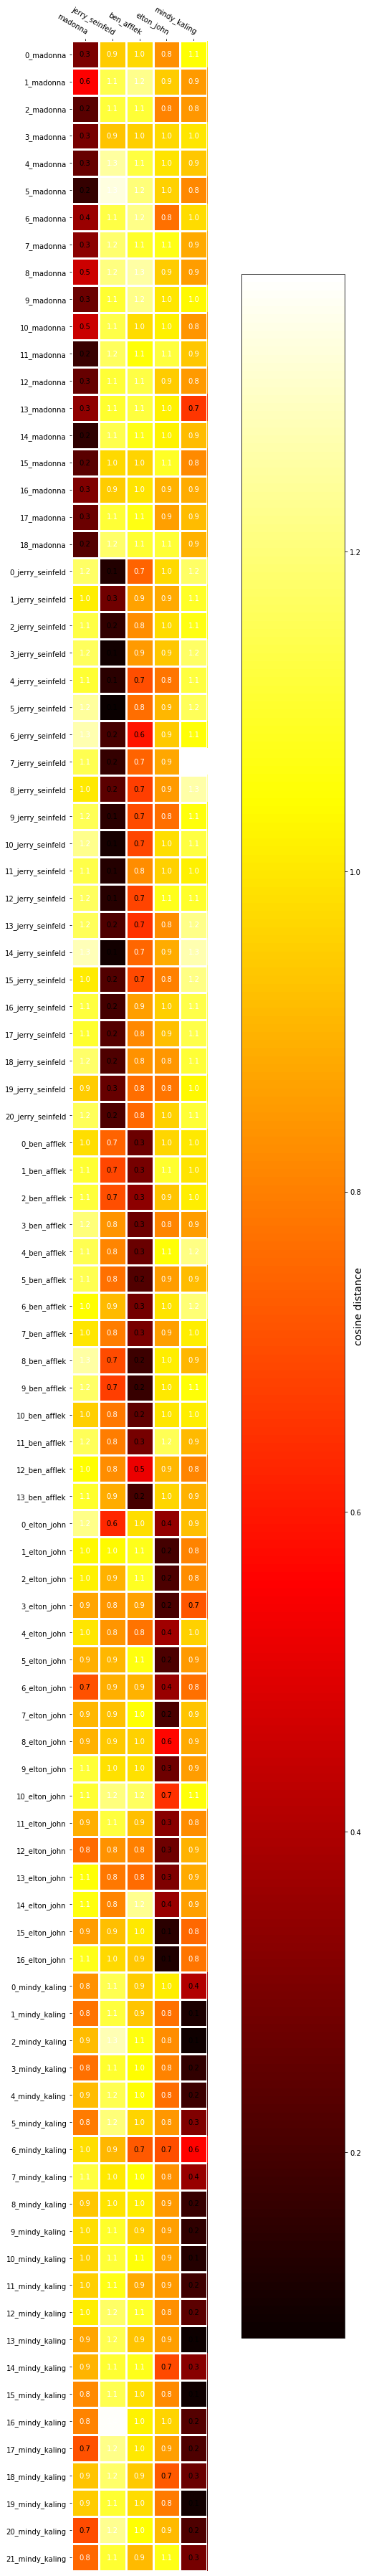

In [16]:
fig, ax = plt.subplots(figsize=(14,50))

im, cbar = heatmap(_dists, _names, _persons, ax=ax,
                   cmap="hot", cbarlabel="cosine distance")
texts = annotate_heatmap(im, valfmt="{x:.1f}")

fig.tight_layout()
plt.show()

I decided to recheck this result with test images because train images contributed to the mean vector and this could be data leak. But with test images the result is the same.

In [17]:
test_faces = {}
test_persons = listdir(join(data_path, 'test'))

for person in test_persons:
    images = listdir(join(data_path, 'test', person))
    
    for i, img_name in enumerate(images):
        pil_image = Image.open(join(data_path, 'test', person, img_name)).convert('RGB')
        
        # mtcnn detections
        face = mtcnn(pil_image)

        if face is None:
            print(f'No test_faces found in image {img_name} of {person}')
            continue
            
        if person not in test_faces:
            test_faces[person] = []
            
        test_faces[person].append(face)

In [18]:
test_face_vectors = {}

for person, _faces in test_faces.items():
    face_batch = torch.stack(_faces)
    vectors = facenet(face_batch).detach().cpu().numpy()
    
    test_face_vectors[person] = [vec for vec in vectors]

In [19]:
pickle.dump(test_face_vectors, open(join(data_path, 'test_face_vectors.pkl'), 'wb'))

In [20]:
test_names, test_vectors = [], []
test_persons, test_mean_person_vectors = [], []
for person, vecs in test_face_vectors.items():
    q_v = []
    for i, vec in enumerate(vecs):
        test_names.append(f'{i}_{person}')
        test_vectors.append(vec)
        q_v.append(vec)
    test_persons.append(person)
    test_mean_person_vectors.append(np.array(q_v).mean(axis=0))

In [21]:
test_dists = np.array([[cosine(v1, v2) for v2 in test_mean_person_vectors] for v1 in test_vectors])

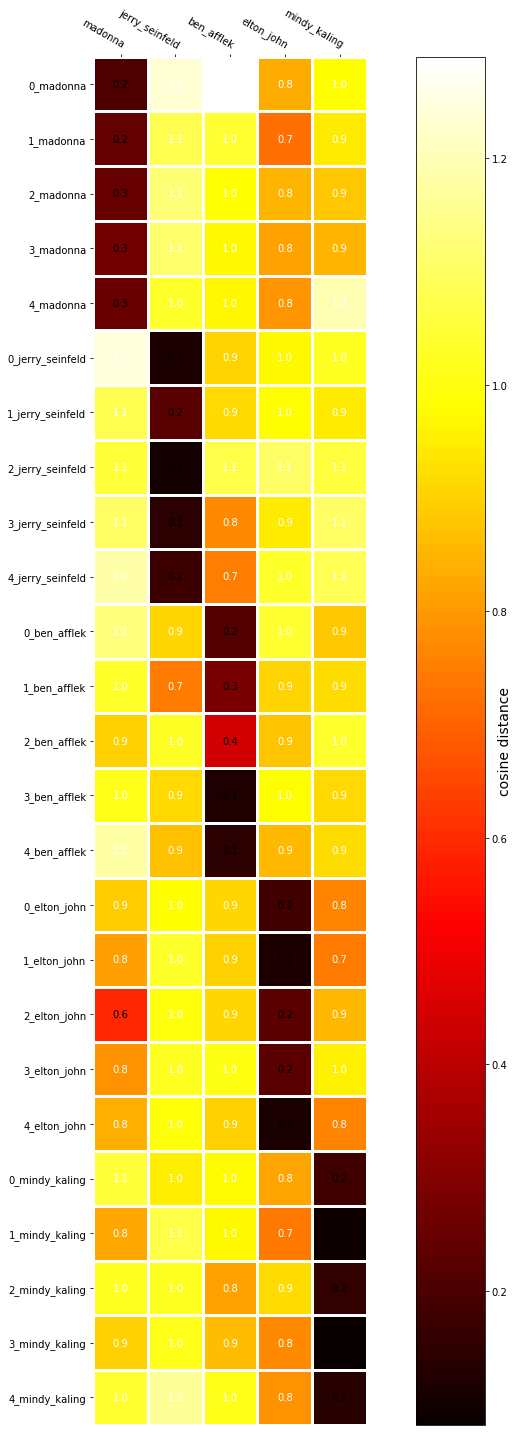

In [22]:
fig, ax = plt.subplots(figsize=(14,20))

im, cbar = heatmap(test_dists, test_names, test_persons, ax=ax,
                   cmap="hot", cbarlabel="cosine distance")
texts = annotate_heatmap(im, valfmt="{x:.1f}")

fig.tight_layout()
plt.show()

## Classifier

In [23]:
train_vec = pickle.load(open(join(data_path, 'train_face_vectors.pkl'), 'rb'))
test_vec = pickle.load(open(join(data_path, 'test_face_vectors.pkl'), 'rb'))

In [24]:
x_train, y_train = [], []
for person, vecs in train_vec.items():
    for vec in vecs:
        y_train.append(person)
        x_train.append(vec)
x_train = np.array(x_train)

In [25]:
x_test, y_test = [], []
for person, vecs in test_vec.items():
    for vec in vecs:
        y_test.append(person)
        x_test.append(vec)
x_test = np.array(x_test)

In [26]:
in_encoder = Normalizer(norm='l2')
x_train = in_encoder.transform(x_train)
x_test = in_encoder.transform(x_test)

out_encoder = LabelEncoder()
out_encoder.fit(y_train)
y_train = out_encoder.transform(y_train)
y_test = out_encoder.transform(y_test)

In [27]:
model = SVC(kernel='linear', probability=True)
model.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [28]:
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)

In [29]:
print('Train acc {:.2f}, test acc {:.2f}'.format(acc_train, acc_test))

Train acc 1.00, test acc 1.00
